<h2> Analyzing Performance of CNN for Audio Processing with MFCC of Varying Orders: </h2>

In [26]:
import json
import librosa
import numpy as np
import tensorflow as tf

In [27]:
# Filepath of encoded data generated from the function in data_loader.py
DATA_PATH = "data.json"

def load_data(data_path = DATA_PATH):
  """
  load_data(data_path) accesses the json file defined by data_path and extracts
  the MFCC data with associated labels for the .wav files located in the subfolders
  of data/ extracted using generate_features() function in data_loader.py.
  """

  # Loading the .json file to read the data
  with open(data_path, "r") as fp:
    data = json.load(fp)

  # Collecting the MFCC vectors and labels, and converting data into numpy array
  mfcc = np.array(data["mfcc"])
  labels = np.array(data["labels"])

  return mfcc, labels

In [28]:
def generate_mfcc_orders(mfcc):
  """
  generate_mfcc_orders(mfcc) returns the first-order delta MFCC and the second-order
  delta MFCC based on the mfcc MFCC vector passed in as argument to the function.
  """

  # Generating first-order MFCC delta
  delta_mfcc = librosa.feature.delta(mfcc, order = 1)

  #Generating second-order MFCC delta
  delta2_mfcc = librosa.feature.delta(mfcc, order = 2)
  return delta_mfcc, delta2_mfcc

In [29]:
from sklearn.model_selection import train_test_split

def split_data(features, labels):
  """
  split_data(features, labels) splits the input data (features, labels) into training
  set, validation set, and testing set split as 60-10-30 i.e. 60% of the input data
  makes up the training set, 10% makes up the validation set, and 30% makes up the
  testing set.
  """
  
  X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.30, random_state = 42)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.15, random_state = 42)
  return X_train, X_test, X_val, y_train, y_test, y_val

In [30]:
import tensorflow.keras as keras

def generate_cnn_model(input_shape):
  """
  generate_cnn_model(input_shape) initializes a CNN model with 3 convolution layer
  with an output channel size of 10, which corresponds to one of the 10 categories
  of music, for an input dimension input_shape.
  """
  
  model = keras.Sequential()

  # First Convolution Layer
  model.add(keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = input_shape))
  model.add(keras.layers.MaxPool2D((3, 3), strides = (2, 2), padding = 'same'))
  model.add(keras.layers.BatchNormalization())

  # Second Convolution Layer
  model.add(keras.layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = input_shape))
  model.add(keras.layers.MaxPool2D((3, 3), strides = (2, 2), padding = 'same'))
  model.add(keras.layers.BatchNormalization())

  # Third Convolution Layer
  model.add(keras.layers.Conv2D(128, (2, 2), activation = 'relu', input_shape = input_shape))
  model.add(keras.layers.MaxPool2D((2, 2), strides = (2, 2), padding = 'same'))
  model.add(keras.layers.BatchNormalization())

  # Converting the neurons into a 1D layer
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(64, activation = 'relu'))
  model.add(keras.layers.Dropout(0.3))

  # Condensing neuron layer into 10 nodes, each corresponding to a music genre label
  model.add(keras.layers.Dense(10, activation = 'softmax'))
  
  print("CNN model loaded.")
  return model

In [31]:
# Loading the MFCC data from data.json
mfcc, labels = load_data(DATA_PATH)

# Generating higher-order delta MFCC from the MFCC vectors
delta_mfcc, delta2_mfcc = generate_mfcc_orders(mfcc = mfcc)

print(mfcc.shape)
print(delta_mfcc.shape)
print(delta2_mfcc.shape)

(9989, 132, 13)
(9989, 132, 13)
(9989, 132, 13)


<h3> CNN trained on MFCC: </h3>

In [7]:
# Splitting dataset into training, testing, and validation set
X_train, X_test, X_validation, y_train, y_test, y_validation = split_data(mfcc, labels)

# Adding extra dimension to data for increased stability
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]

print(mfcc.shape)

# Generating input dimension to the CNN
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
print(input_shape)

(9989, 132, 13)
(132, 13, 1)


In [8]:
# Generating CNN model for input dimension based on MFCC
model_mfcc = generate_cnn_model(input_shape)

# Initializing Adam optimizer for CNN model
optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

# Compiling the model with Adam optimizer
model_mfcc.compile(optimizer = optimizer,
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

model_mfcc.summary()

/Users/xenexjoshi/Music Genre Classification/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


CNN model loaded.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 130, 11, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 65, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 65, 6, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 63, 4, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 2, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 31, 1, 128)     │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 1, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,394 (720.29 KB)

 Trainable params: 183,946 (718.54 KB)

 Non-trainable params: 448 (1.75 KB)

In [9]:
# Training model on the training set, while using the validation to check validation accuracy after each epoch
base_history = model_mfcc.fit(X_train, y_train, validation_data = (X_validation, y_validation), epochs = 30, batch_size = 32)

Epoch 1/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.2416 - loss: 2.4206 - val_accuracy: 0.4261 - val_loss: 1.6276
Epoch 2/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.4556 - loss: 1.5422 - val_accuracy: 0.5462 - val_loss: 1.2712
Epoch 3/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.5285 - loss: 1.3165 - val_accuracy: 0.5663 - val_loss: 1.1819
Epoch 4/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.5752 - loss: 1.1673 - val_accuracy: 0.5929 - val_loss: 1.0995
Epoch 5/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.6278 - loss: 1.0342 - val_accuracy: 0.6273 - val_loss: 1.0410
Epoch 6/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.6666 - loss: 0.9465 - val_accuracy: 0.6482 - val_loss: 0.9759
Epoch 7/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.6888 - loss: 0.8648 - val_accuracy: 0.6549 - val_loss: 0.9531
Epoch 8/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.7308 - loss: 0.7764 - val_acc

In [10]:
# Evaluating the model with the testing set
_, accuracy = model_mfcc.evaluate(X_test, y_test)
print("Model accuracy: " + str(round(100 * accuracy, 3)) + "%.")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7442 - loss: 0.8231
Model accuracy: 75.209%.


<h3> CNN trained on MFCC and first-order delta MFCC: </h3>

In [11]:
# Merging MFCC and delta(MFCC) into a 2d structure to pass onto the CNN
complex_feature = np.stack([mfcc, delta_mfcc], axis = -1)
print(complex_feature.shape)

# Splitting dataset into training, testing, and validation set
X_train, X_test, X_validation, y_train, y_test, y_validation = split_data(complex_feature, labels)

# Generating input dimension to the CNN
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
print(input_shape)

(9989, 132, 13, 2)
(132, 13, 2)


In [12]:
# Generating CNN model for input dimension based on MFCC and delta MFCC
model_delta = generate_cnn_model(input_shape)

# Initializing Adam optimizer for CNN model
optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

# Compiling the model with Adam optimizer
model_delta.compile(optimizer = optimizer,
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

model_delta.summary()

CNN model loaded.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 130, 11, 32)    │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 65, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 65, 6, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 63, 4, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 2, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 31, 1, 128)     │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 1, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,682 (721.41 KB)

 Trainable params: 184,234 (719.66 KB)

 Non-trainable params: 448 (1.75 KB)

In [13]:
# Training model on the training set, while using the validation to check validation accuracy after each epoch
first_order_history = model_delta.fit(X_train, y_train, validation_data = (X_validation, y_validation), epochs = 30, batch_size = 32)

Epoch 1/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.2736 - loss: 2.3614 - val_accuracy: 0.3756 - val_loss: 1.7187
Epoch 2/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.4708 - loss: 1.5123 - val_accuracy: 0.5253 - val_loss: 1.3018
Epoch 3/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.5360 - loss: 1.3229 - val_accuracy: 0.5643 - val_loss: 1.1719
Epoch 4/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.5873 - loss: 1.1523 - val_accuracy: 0.6158 - val_loss: 1.0892
Epoch 5/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.6197 - loss: 1.0442 - val_accuracy: 0.6168 - val_loss: 1.0556
Epoch 6/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.6625 - loss: 0.9550 - val_accuracy: 0.6339 - val_loss: 1.0223
Epoch 7/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.6911 - loss: 0.8657 - val_accuracy: 0.6311 - val_loss: 1.0072
Epoch 8/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.7138 - loss: 0.8016 - val_accu

In [14]:
# Evaluating the model with the testing set
_, accuracy = model_delta.evaluate(X_test, y_test)
print("Model accuracy: " + str(round(100 * accuracy, 3)) + "%.")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7415 - loss: 0.8291
Model accuracy: 74.675%.


<h3> CNN trained on MFCC, first-order, and second-order delta MFCC: </h3>

In [15]:
# Merging MFCC, delta_MFCC, and delta2_MFCC into a 2D structure to pass onto the CNN
complex_feature = np.stack([mfcc, delta_mfcc, delta2_mfcc], axis = -1)
print(complex_feature.shape)

# Splitting dataset into training, testing, and validation set
X_train, X_test, X_validation, y_train, y_test, y_validation = split_data(complex_feature, labels)

# Generating input dimension to the CNN
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
print(input_shape)

(9989, 132, 13, 3)
(132, 13, 3)


In [16]:
# Generating CNN model for input dimension based on MFCC, delta MFCC, and delta_2 MFCC
model_delta = generate_cnn_model(input_shape)

# Initializing Adam optimizer for CNN model
optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

# Compiling the model with Adam optimizer
model_delta.compile(optimizer = optimizer,
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

model_delta.summary()

CNN model loaded.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 130, 11, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 65, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 65, 6, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 63, 4, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 2, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 31, 1, 128)     │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 1, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,970 (722.54 KB)

 Trainable params: 184,522 (720.79 KB)

 Non-trainable params: 448 (1.75 KB)

In [17]:
# Training model on the training set, while using the validation to check validation accuracy after each epoch
second_order_history = model_delta.fit(X_train, y_train, validation_data = (X_validation, y_validation), epochs = 30, batch_size = 32)

Epoch 1/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.2700 - loss: 2.2179 - val_accuracy: 0.4385 - val_loss: 1.6413
Epoch 2/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.4736 - loss: 1.4983 - val_accuracy: 0.5405 - val_loss: 1.2872
Epoch 3/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.5660 - loss: 1.2572 - val_accuracy: 0.5968 - val_loss: 1.1679
Epoch 4/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.6011 - loss: 1.1466 - val_accuracy: 0.6111 - val_loss: 1.0900
Epoch 5/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.6462 - loss: 1.0110 - val_accuracy: 0.6225 - val_loss: 1.0563
Epoch 6/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.6617 - loss: 0.9462 - val_accuracy: 0.6273 - val_loss: 1.0198
Epoch 7/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.6997 - loss: 0.8617 - val_accuracy: 0.6473 - val_loss: 0.9787
Epoch 8/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.7290 - loss: 0.7971 - val_accu

In [18]:
# Evaluating the model with the testing set
_, accuracy = model_delta.evaluate(X_test, y_test)
print("Model accuracy: " + str(round(100 * accuracy, 3)) + "%.")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7530 - loss: 0.7969
Model accuracy: 75.309%.


<h3> Analysis: </h3>

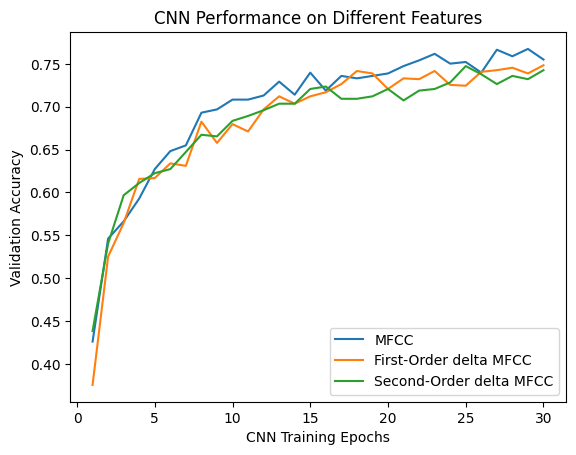

In [19]:
import matplotlib.pyplot as plt

# Generating the training validation accuracy for the three models created above
x_range = range(1, 31)
plt.plot(x_range, base_history.history['val_accuracy'], label = 'MFCC')
plt.plot(x_range, first_order_history.history['val_accuracy'], label = 'First-Order delta MFCC')
plt.plot(x_range, second_order_history.history['val_accuracy'], label = 'Second-Order delta MFCC')
plt.xlabel('CNN Training Epochs')
plt.ylabel('Validation Accuracy')
plt.title('CNN Performance on Different Features')
plt.legend()
plt.show()

<h3> Conclusion: </h3>

<p> The model accuracy on the testing set for the three CNN models trained on MFCC, MFCC with first-order delta MFCC, and MFCC with first and second-order MFCC are 75.209%, 74.675%, and 75.409% repectively. Each model was trained on the same training set, and evaluated on the same testing set with each model trained for 30 iterations with a batch size of 32. Additionally, we can observe the stability of the model on the plot above. In terms of model accuracy, all 3 models behave equally as well, with the model that considers second-order delta MFCC performing slightly better than the other two models. In terms of model stability, the more complicated model i.e. model that takes higher order MFCC seems to generate more stable results. 

Hence, the most ideal feature for music genre classification (using CNN) appears to be MFCC paired with first-order, and second-order delta MFCC. Although computationally, the base model with MFCC is preferred due to its similar accuracy to other models, with slight trade-off in terms of stability of the model. </p>